## Implementation of Neural Network Regression in Pytorch

In [36]:
#%pip install torch
#%pip install -U scikit-learn
#%pip install seaborn

In [15]:
import torch
from torch import nn
import sklearn as skl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
# https://archive.ics.uci.edu/
# https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/
# https://paperswithcode.com/datasets

from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

In [17]:
np.shape(housing.data)

(20640, 8)

In [18]:
np.shape(housing.target)

(20640,)

In [19]:
print(housing.feature_names)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


<Axes: >

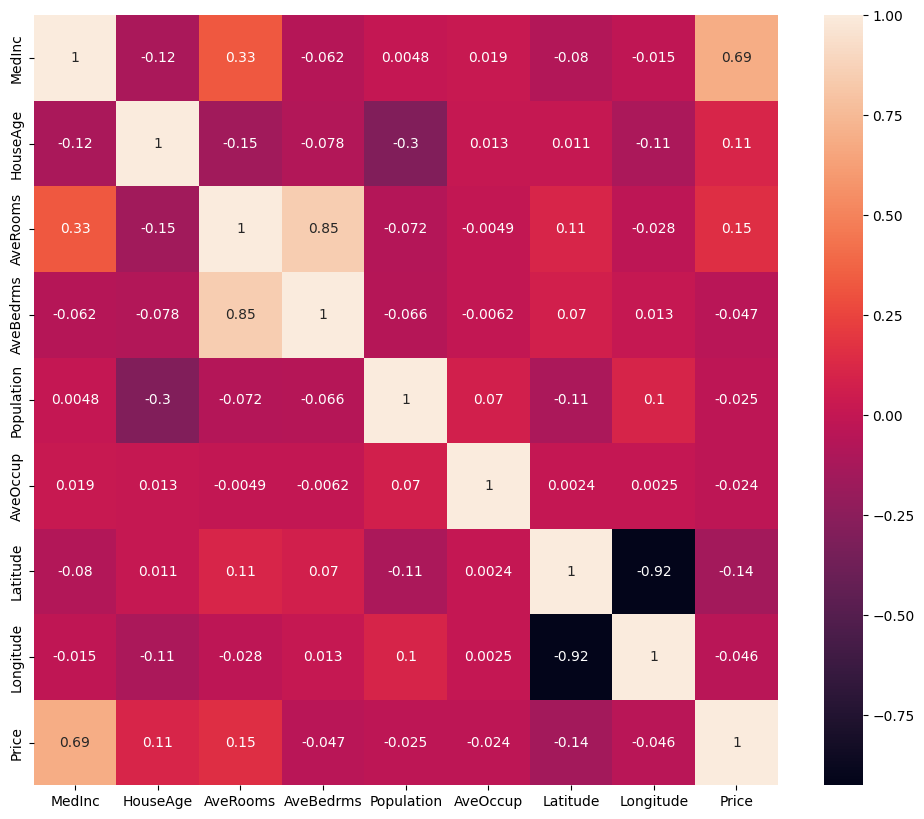

In [20]:
cols = list(housing.feature_names) + ['Price']
house_df = pd.DataFrame(np.hstack([housing.data, np.atleast_2d(housing.target).T]), columns=cols)
plt.figure(figsize=(12,10))
sns.heatmap(house_df.corr(), annot=True)

## Load data

In [21]:
X, y = housing.data, housing.target
X = X.astype(np.float32)
y = y.astype(np.float32)
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, y, random_state=1)

In [22]:
print(f'Xtrain dim: {X_train.shape}')
print(f'Xtrain dim: {y_train.shape}')
print(f'Xtrain dim: {X_test.shape}')
print(f'Xtrain dim: {y_test.shape}')

Xtrain dim: (15480, 8)
Xtrain dim: (15480,)
Xtrain dim: (5160, 8)
Xtrain dim: (5160,)


In [23]:
y_test

array([3.55 , 0.707, 2.294, ..., 0.588, 2.108, 0.875], dtype=float32)

In [24]:
len(np.unique(y_train))

3608

## Data Class

We careate a PyTorch-compatible dataset to be used with Pytorch DataLoader. It has three defs: 
- $__init__$ or the constructor, where most of the work is done.
- $__len__$ returning dataset length
-  $__getitem__$ for retrieving an individual item using an index.

In [25]:
import torch.utils.data as Data

class HouseData(Data.Dataset):
    def __init__(self, X, y):
        #scaler = skl.preprocessing.StandardScaler()
        scaler = skl.preprocessing.MinMaxScaler()
        self.X = torch.from_numpy(scaler.fit_transform(X.astype(np.float32)))
        self.y = torch.from_numpy(y.astype(np.float32))
    
    def __getitem__(self, i):
        return self.X[i, :], self.y[i]

    def __len__(self):
        return len(self.y)

In [26]:
sXtrain = HouseData(X_train, y_train)
sXtest = HouseData(X_test, y_test)

## Neural Network Class

In [27]:
class Model(nn.Module):
    def __init__(self, n_features, hiddenA, hiddenB):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(n_features, hiddenA)
        self.fc2 = nn.Linear(hiddenA, hiddenB)
        self.output = nn.Linear(hiddenB, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)

#### While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

#### DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [28]:
batch_size = 16
train_loader = Data.DataLoader(sXtrain, batch_size=batch_size, shuffle=True, num_workers= 0)
test_loader = Data.DataLoader(sXtest, batch_size=batch_size, shuffle=True, num_workers= 0)

In [29]:
x, y = next(iter(train_loader))
print(x.shape)
print(y.shape)

torch.Size([16, 8])
torch.Size([16])


In [30]:
net = Model(X_train.shape[1], 100, 50)

In [31]:
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

## Training loop

In [32]:
from torch.nn import functional as F

n_epochs = 50
all_losses = []
for epoch in range(n_epochs):
    losses = []
    total = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        y_pred = net(x)
        loss = loss_function(y_pred, torch.unsqueeze(y,dim=1))

        loss.backward()
        
        optimizer.step()
        
        #progress_bar.set_description(f'Loss: {loss.item():.3f}')
        
        losses.append(loss.item())
        total += 1

    epoch_loss = sum(losses) / total
    all_losses.append(epoch_loss)
                
    mess = f"Epoch #{epoch+1} \t Loss: {all_losses[-1]:.3f}"
    print(mess)

Epoch #1 	 Loss: 1.161
Epoch #2 	 Loss: 0.776
Epoch #3 	 Loss: 0.626
Epoch #4 	 Loss: 0.562
Epoch #5 	 Loss: 0.550
Epoch #6 	 Loss: 0.542
Epoch #7 	 Loss: 0.536
Epoch #8 	 Loss: 0.531
Epoch #9 	 Loss: 0.527
Epoch #10 	 Loss: 0.523
Epoch #11 	 Loss: 0.519
Epoch #12 	 Loss: 0.516
Epoch #13 	 Loss: 0.512
Epoch #14 	 Loss: 0.509
Epoch #15 	 Loss: 0.507
Epoch #16 	 Loss: 0.504
Epoch #17 	 Loss: 0.502
Epoch #18 	 Loss: 0.499
Epoch #19 	 Loss: 0.497
Epoch #20 	 Loss: 0.495
Epoch #21 	 Loss: 0.493
Epoch #22 	 Loss: 0.491
Epoch #23 	 Loss: 0.489
Epoch #24 	 Loss: 0.487
Epoch #25 	 Loss: 0.486
Epoch #26 	 Loss: 0.485
Epoch #27 	 Loss: 0.483
Epoch #28 	 Loss: 0.481
Epoch #29 	 Loss: 0.480
Epoch #30 	 Loss: 0.479
Epoch #31 	 Loss: 0.477
Epoch #32 	 Loss: 0.476
Epoch #33 	 Loss: 0.474
Epoch #34 	 Loss: 0.473
Epoch #35 	 Loss: 0.473
Epoch #36 	 Loss: 0.471
Epoch #37 	 Loss: 0.469
Epoch #38 	 Loss: 0.469
Epoch #39 	 Loss: 0.468
Epoch #40 	 Loss: 0.467
Epoch #41 	 Loss: 0.466
Epoch #42 	 Loss: 0.464
E

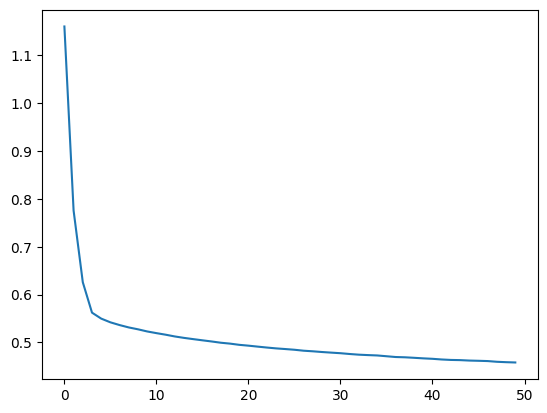

In [33]:
plt.plot(all_losses)

## Testing

In [34]:
y_pred = []
y_true = []
net.train(False)
for inputs, targets in test_loader:
    y_pred.extend(net(inputs).data.numpy())
    y_true.extend(targets.numpy())

In [35]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

MAE: 1.1410726308822632
MSE: 2.297762632369995
